# Tercer Trabajo para el curso de Técnicas en Aprendizaje Estadístico

## Integrantes:
- Julián Alejandro Usuga Ortiz
- Santiago Campos Giraldo
- Juan José Hurtado Álvarez
- Santiago Poveda Grajales
- Diego de Oliveira Hitzges

# Planteamiento del Problema
En este trabajo nuestro objetivo es clasificar e indentificar imagenes de personas que tienen (o no) gafas.

Para esto hemos sido proporcionados una base de datos con estas imagenes.

El acercamiento que le dimos a este problema está descrito en las siguientes celdas.


Se cargan las librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import glob
import pickle
import re

#Access to Google Drive
#Cargamos las imagenes guardadas en drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Primeramente se leen las imágenes

In [2]:
#get all names (including their path) of the images
# Obtenemos los nombres de archivos de las imagenes (incluidos sus rutas)
filenames = glob.glob("drive/MyDrive/Colab Notebooks/faces_4/*/*.pgm")

f"Numero de imagenes: {len(filenames)}"

'Numero de imagenes: 624'

Observamos la cantidad de imágenes con las que vamos a trabajar



Visualizamos las imagenes y vemos que las estas están en blanco/negro y tienen poca resolucion lo que nos facilita un paso, comprimir las imagenes

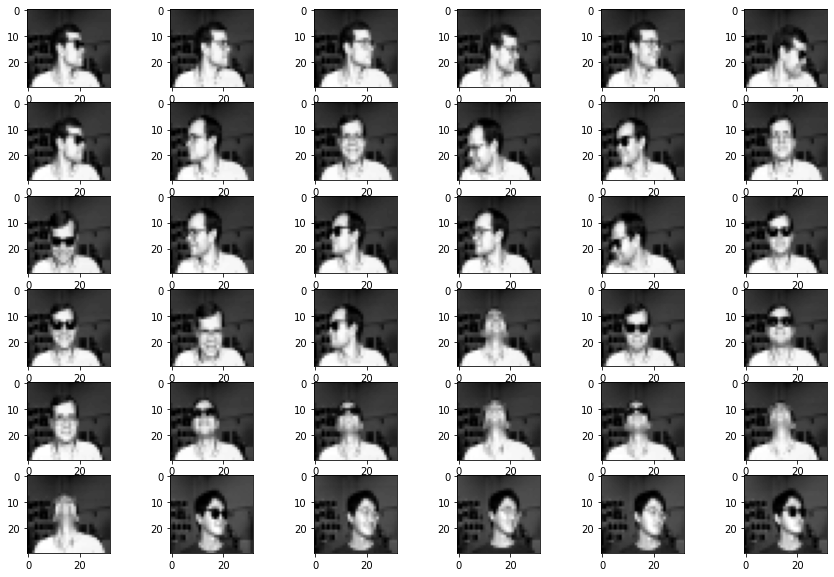

In [3]:
import re

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


fig = plt.figure(figsize=(15, 10))
rows = 6
columns = 6

for index in range(1, rows*columns + 1):
  fig.add_subplot(rows, columns, index)
  image = read_pgm(filenames[index], byteorder='<')
  plt.imshow(image, plt.cm.gray)
  

plt.show()

Posteriormente se crea una lista de imágenes, donde se guardarán las imágenes cargadas como un Numpy-array.
Para darles un mejor manejo, se les aplana para que queden como una simple fila, la cual se etiqueta adicionalmente con **1** si hace referencia desde su nombre a una persona con gafas ó **0** si la persona no las posee y finalmente se añaden una a una a la lista de Imágenes _"images"_.

In [ ]:
#we create a list containing all the images as numpy array
images = []
for file in filenames:
  #load images as numpy-arrays 
	img = cv2.imread(file,-1)
  #flatten the arrays
	img = img.flatten()
	
  #add label at the end of the array: 1 for sunglass, 0 else
	if "sunglasses" in file:
		img = np.append(img,1)
	else:
		img = np.append(img,0)

  #add array to list of images
	images.append(img)

Se crea el DataSet en forma de matriz, en la cual cada columna es un arreglo de una imagen "aplanada", y la última fila-vector es correspondiente a las etiquetas binarias de las Y.


In [ ]:
#create numpy matrix from former list of images
#every column is the array of one image, while the last entry/row is the corresponding label
data = np.asarray(images).T

#split the labels Y
X_data = data[:-1,:]
Y_data = data[-1,:].reshape(1,-1)

#normalize X
X_mean = np.mean(X_data, axis=1).reshape(X_data.shape[0],1)
X_std = np.std(X_data, axis=1).reshape(X_data.shape[0],1)
X_data = (X_data - X_mean) / X_std

Se separan los datos en *Training and Test set*.

Todas las fotos de las últimas 4 personas serán el Set de Testeo, por otro lado, todas las fotos de las primeras 16 personas serán el Set de Entrenamiento. 
Por cada persona se tienen 32 imágenes. 
Por lo tanto las primeras 512 imágenes serán usadas para Entrenamiento.

In [ ]:
#training set
X_train = X_data [:,:512]
Y_train = Y_data [:,:512]

#test set
X_test = X_data [:,512:]
Y_test = Y_data [:,512:]

In [ ]:
#Dimensions
n_x = len(X_train)
m = len(X_train[0])

print(n_x,",", m)

Observamos la distribución de los datos 

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(X_data)
plt.show()

#Ahora se pasa a la elaboración del Modelo de Regresión Logística

##¿ Por qué Regresión Logística ?

Generalmente es un tipo de análisis de regresión usado para clasificar variables categóricas (En nuestro caso **1 o 0** para determinar si una persona posee o no gafas en la imágen) en función de las variables predictoras. 
Entonces a la hora de predecir una salida discreta (Binaria, no continua), este algoritmo de aprendizaje supervisado se ajusta a la clasificación que buscamos hacer.


Ahora sí pasamos a la elaboración del modelo.

Primero se inicializan los parámetros *W* y *b*

In [ ]:
def init_parameters():
	w = np.random.randn(n_x,1) * 0.01
	b = 0
	return(w,b)

Se definen las siguientes funciones de activación de la capa de salida y por qué su selección:

*   Tangente Hiperbólica: Es una función parecida a la sigmoidal que para conjuntos de datos con media cercana a 0, funciona muy bien.
*   Sigmoidal: Función de fórmula muy simple usada generalmente para problemas de clasificación binaria y regresión logística.



In [ ]:
def tanh(Z):
  e=  np.exp(Z)
  e_n= np.exp(-Z)
  A= (e - e_n)/ (e + e_n)
  return A 

def sigmoid(Z):
	A = 1/(1+np.exp(-Z))
	return (A)

Se calcula la etiqueta de Y estimado

In [ ]:
def calc_Y_hat(X,w,b, activation_function= "sigmoid"):
  Z = np.dot(w.T,X) + b
  if (activation_function=="sigmoid"): Y_hat = sigmoid(Z)
  elif (activation_function=="tanh"): 
    Y_hat = tanh(Z)
    Y_hat = (Y_hat + 1) / 2

  
  return (Y_hat)

Se define la Función de Costo

In [ ]:
def cost_func(Y,Y_hat):
  m = len(Y_hat[0])
  cost = -1/m * np.sum(np.multiply(Y,np.log(Y_hat)) + np.multiply(1-Y,np.log(1-Y_hat)))
  return(cost)

Así mismo el *Accuracy*

In [ ]:
def accuracy(Y,Y_hat):
  
  #calculate difference between label and its prediction
  Diff = Y - Y_hat
  total = len(Y_hat[0])

  #if total value of difference is smaller than 1/2, the prediction would be rounded correctly
  correctly_predicted = 0
  for elem in Diff[0]:
    if -1/2 < elem < 1/2:
      correctly_predicted += 1

  #rate of correct predictions
  acc = correctly_predicted / total
  acc = str(round(acc*100))+"%"

  return(acc)


Ahora los Gradientes de *W* y *b*

###Por qué Gradient Descent ?

Para algorítmos de predicción como la Regresión Logística, Regresión lineal o Regresión polinómica es un método de entrenamiento que brinda muy buenos resultados para optimizar el algorítmo, en comparación de otros métodos como Mínimos cuadrados para minimizar la función de costo y el MSE, ya que por medio de las derivadas se va encontrando el óptimo que minimiza nuestro error.

In [ ]:
def grad(X,Y,Y_hat):
	dZ = Y_hat - Y
	dw = 1/m * np.dot(X,dZ.T)
	db = 1/m * np.sum(dZ)
	return(dw,db)

Luego de esto se actualizan de nuevo los parámetros *W* y *b*

In [ ]:
def actualize_parameters(w,b,dw,db,learning_rate):
	w = w - learning_rate * dw
	b = b - learning_rate * db
	return w,b

Se almacenan los parámetros obtenidos en una fila de texto separada

In [ ]:
#Save the obtained parameters in a separate text-file
def save_parameters(parameters):
	f = open("parameters.txt", "wb")
	pickle.dump(parameters,f)
	f.close()

###Ahora se define la función de la Regresión Logística



In [ ]:
def logistic_regression(X_train,Y_train,learning_rate,epochs,print_cost=False, activation_function="sigmoid"):
	
  #initiate parameters
  w,b = init_parameters()
	
  for e in range(epochs):

    #calculate prediction
    Y_hat = calc_Y_hat(X_train,w,b, activation_function)
		
    #calculate cost and precision
    cost = cost_func(Y_train,Y_hat)
    acc = accuracy(Y_train,Y_hat)
    if print_cost and e%10==0:
       print("epoch: " + str(e)+ ", cost: "+ str(round(cost,4))+ ", accuracy: "+ acc)
		
    #calculate gradients
    dw,db = grad(X_train,Y_train,Y_hat)

    #actualize weights
    w,b = actualize_parameters(w,b,dw,db,learning_rate)

  #calculate final cost
  print("training cost = " +str(round(cost,4)) +" |", "training accuracy = " +acc)

  #save the trained parameters
  save_parameters((w,b))

Leer en los parámetros guardados anteriormente

In [ ]:
#Read in former saved parameters
def read_parameters():
	f = open("parameters.txt", "rb")
	parameters = pickle.load(f)
	f.close()
	return parameters

Función para obtener el *Error de Testeo*




In [ ]:
def test_parameters(X_test,Y_test, activation_function= " sigmoid"):
    
    #load trained parameters
    parameters = read_parameters()
    w,b = parameters

    #calculate prediction
    Y_hat = calc_Y_hat(X_test,w,b, activation_function)
    
    #calculate cost
    cost = round(cost_func(Y_test,Y_hat),4)
    acc = accuracy(Y_test,Y_hat)

    print("test cost = " +str(cost) +" |", "test accuracy = " + acc)

#Se procede a hacer la clasificación

Entonces se usará una vez la función *Sigmoid* y una vez el *TanH* como función de activación (para el caso de TanH aún transformamos el resultado sumando 1 y dividiendo por 2 para que el resultado se quede entre 0 y 1, teniendo la divisón en 1/2 de nuevo). Por último, para hacer la predicción al final (y también el calculo del *Accuracy*) se decidió que una observación se clasifica como clase 1 si el reslutado del modelo está entre 1/2 y 1 (La persona posee Gafas), y por otro lado como clase 0 si está entre 0 y 1/2 (La persona no tiene Gafas).

### Clasificación con Función de Activación Sigmoid 


In [ ]:
#Execute Training
np.random.seed(101)
logistic_regression(X_train,Y_train,0.01,150,print_cost=False)

In [ ]:
#Test parameters
test_parameters(X_test,Y_test, activation_function= "sigmoid")

### Clasificación con Función de Tángente Hiperbólica

In [ ]:
#Execute Training
np.random.seed(101)
logistic_regression(X_train,Y_train,0.01,150,print_cost=False, activation_function="tanh")

In [ ]:
#Test parameters
test_parameters(X_test,Y_test, activation_function="tanh")

Visualizamos las imagenes con la mayor presición con nuestra regresión, presicion menores a 0.1 para imagenes de sujetos que no tienen gafas y mayores a 0.9 para sujetos con gafas

In [ ]:
w, b = read_parameters()
Y_hat = calc_Y_hat(X_train, w, b, "tanh")

# Vamos a visualizar esta clasificacion sobre nuestro array de testeo
predicted_no_glass = []
predicted_glass = []
for index, i in np.ndenumerate((Y_hat < 0.1)[0]):
  if i:
    predicted_no_glass.append(filenames[index[0]])
for index, i in np.ndenumerate((Y_hat > 0.9)[0]):
  if i:
    predicted_glass.append(filenames[index[0]])


for files in [predicted_glass, predicted_no_glass]:
  fig = plt.figure(figsize=(10, 10))
  rows = 6
  columns = 6
  err = 0
  for index in range(1, rows*columns + 1):
    try:
      image = read_pgm(files[index], byteorder='<')
    except ValueError:
      err = err + 1
    else:
      fig.add_subplot(rows, columns, index-err)
      image = read_pgm(files[index], byteorder='<')
      plt.imshow(image, plt.cm.gray)
    
  plt.show()

## Bibliografias

*   [StackOverflow](https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm)
*   [Wikipedia, Regresión Logistica](https://en.wikipedia.org/wiki/Logistic_regression)

